In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Dense,Dropout,Concatenate
import tensorflow_probability as tfp
from tensorflow.keras import backend as K

x_path = "data/"
y_path = "RECOLA/ratings_individual/ratings_individual/arousal/"
label_delay = 4
frame_length = 10
frame_step = 2
dropout_rate = 0.1

from numpy.random import seed
import matplotlib.pyplot as plt
seed(1)

In [2]:
#split data into frames for training
def framer(x,y, frame_length, frame_step):
    num_steps,num_features = x.shape
    num_annotators = y.shape[-1]
    x_out = []
    y_out = []
    step = 0
    while (step+frame_length <= num_steps):
        frame_x = x[step:step+frame_length,:]
        frame_y = y[step:step+frame_length,:]
        x_out.append(frame_x)
        y_out.append(frame_y)
        step = step+frame_step
    
    x_out = np.array(x_out)
    y_out = np.array(y_out)
    
    return x_out, y_out

#read data from csv files and align
def read_data(file_name, x_path, y_path):
    #read input data
    x_file = x_path + file_name
    df = pd.read_csv(x_file,sep=";")
    x = df.drop(['name','frameTime'],axis=1).to_numpy()

    #read output data
    y_file = y_path + file_name
    df = pd.read_csv(y_file,sep=";")
    y = df.drop("time",axis=1).to_numpy()

    #shift labels and match lengths
    trunc_front = np.int_(label_delay/0.04)
    trunc_back = trunc_front + x.shape[0]
    y = y[trunc_front:trunc_back,:]

    return x,y

def scale_train_inputs(x):
    #scale input features to range 0-1
    #https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
    x_flat = x.reshape(-1, x.shape[-1])
    xmin = np.amin(x_flat, axis=0)
    xmax = np.amax(x_flat, axis=0)
    scaled = (x-xmin)/(xmax-xmin)
    return scaled, xmin, xmax

def scale_test_inputs(x, xmin, xmax):
    scaled = (x-xmin)/(xmax-xmin)
    return scaled

def scale_train_labels(y):
    y_flat = y.reshape(-1, y.shape[-1])
    ymean = np.mean(y_flat, axis=0)
    ystd = np.std(y_flat, axis=0)
    scaled = (y-ymean)/(4*ystd)
#     print(y.shape)
    return scaled, ymean, ystd

def scale_test_labels(y, ymean, ystd):
    scaled = (y-ymean)/(4*ystd)
    return scaled

def ccc(x, y):
#     ccc = 0
    x = tf.reshape(x, tf.shape(x)[0:-1])
    y = tf.reshape(y, tf.shape(y)[0:-1])
#     print(x.shape)
    x_mean = tf.math.reduce_mean(x,axis=-1)
    y_mean = tf.math.reduce_mean(y,axis=-1)
#     print(x_mean.shape)
    x_var = tf.math.reduce_variance(x,axis=-1)
    y_var = tf.math.reduce_variance(y,axis=-1)
#     print(x_var.shape)
    
    cov = tfp.stats.covariance(x, y, sample_axis=-1, event_axis=0)
#     print(cov.shape)
    cov = tf.linalg.diag_part(cov)
#     print(cov.shape)
    ccc = (2*cov)/(x_var+y_var+tf.square((x_mean-y_mean)))
    ccc = tf.math.reduce_mean(ccc)
#     print(ccc)
    return ccc

def my_ccc(x, y):
    x = x.flatten()
    y = y.flatten()
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_var = np.var(x)
    y_var = np.var(y)
    
    cov = np.cov(x,y)[0,1]
    ccc = (2*cov)/(x_var+y_var+(x_mean-y_mean)**2)
    
#     print(cov, x_mean, y_mean, x_var, y_var)
    return ccc

#normalize features to normal distribution
def normalize_train_inputs(x):
    
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    
    features = (x-mean)/std
    
    return features, mean, std

#rescale labels to normal distribution/3
def normalize_labels(y):
    
    mean = np.mean(y, axis=0)
    std = np.std(y, axis=0)
    
    y = (y-mean)/(3*std)
    y = np.clip(y,a_min=-1,a_max=1)
    
    return y

def my_nll(y_true, y_pred, y_pred_std):
    
    mean = y_pred
    variance = np.square(y_pred_std)
    nll = []
    for i in range(6):
        nll.append((np.log(variance) / 2 + ((y_true[:,frame_length-1,i] - mean) ** 2) / (2 * variance)))
        
    nll = np.mean(np.array(nll))
    return nll

In [3]:
#extract data
x_train = []
y_train = []
x_test = []
y_test = []

#training data
for i in range(1,10):
    file_name = "train_" + str(i) + ".csv"
    print(file_name)
    x,y = read_data(file_name,x_path,y_path)
#     y = normalize_labels(y)
    x,y = framer(x,y,frame_length,frame_step)
    x_train.append(x)
    y_train.append(y)

x_train = np.vstack(x_train)
y_train = np.vstack(y_train)
#scale input features to range 0-1
x_train, xmin, xmax = scale_train_inputs(x_train)
# y_train, ymean, ystd = scale_train_labels(y_train)
# y_train, ymin, ymax = scale_train_inputs(y_train)

#test(devel) data
for i in range(1,10):
    file_name = "dev_" + str(i) + ".csv"
    print(file_name)
    x,y = read_data(file_name,x_path,y_path)
#     y = normalize_labels(y)
    x,y = framer(x,y,frame_length,frame_step)
    x_test.append(x)
    y_test.append(y)

x_test = np.vstack(x_test)
y_test = np.vstack(y_test)
#scale input features to range 0-1 from learned scaling
x_test = scale_test_inputs(x_test, xmin, xmax)
# y_test = scale_test_labels(y_test, ymean, ystd)
# y_test = scale_test_inputs(y_test, ymin, ymax)

#obtain individual ratings for ambiguity modelling
y_train_multi = [y_train[:,:,i].reshape(*y_train.shape[0:-1],1) for i in range(6)]
y_test_multi = [y_test[:,:,i].reshape(*y_train.shape[0:-1],1) for i in range(6)]
y_train_multi = np.concatenate(y_train_multi, axis=2)
y_test_multi = np.concatenate(y_test_multi, axis=2)

#obtain stdev for ambiguity modelling
y_train_var = np.var(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test_var = np.var(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

#obtain mean for gold standard training (average of all raters)
y_train = np.mean(y_train,axis=-1).reshape(*y_train.shape[0:-1],1)
y_test = np.mean(y_test,axis=-1).reshape(*y_test.shape[0:-1],1)

#concat mean and stdev for normal distribution approximation
# y_train_normal = np.concatenate([y_train, y_train_std], axis=2)
# y_test_normal = np.concatenate([y_test, y_test_std], axis=2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_multi.shape)
# print(y_test_multi.shape)

# import matplotlib.pyplot as plt
print(y_train_var.shape)

train_1.csv
train_2.csv
train_3.csv
train_4.csv
train_5.csv
train_6.csv
train_7.csv
train_8.csv
train_9.csv
dev_1.csv
dev_2.csv
dev_3.csv
dev_4.csv
dev_5.csv
dev_6.csv
dev_7.csv
dev_8.csv
dev_9.csv
(33264, 10, 88)
(33264, 10, 1)
(33264, 10, 88)
(33264, 10, 1)
(33264, 10, 6)
(33264, 10, 1)


In [64]:
#build NIG 4 param model
def my_NIG_loss(y_true, y_pred):
    #train the model on NLL loss, given the 6 annotations
    
    nll = 0
    
    #4 parameters of NIG prior
    alpha = y_pred[:,:,0]
    beta = y_pred[:,:,1]
    gamma = y_pred[:,:,2]
    nu = y_pred[:,:,3]
    
    gamma2 = 2*alpha*nu*y_pred[:,:,6]/6
    omega = 2*beta*(1+nu)
    rcoeff1 = 0.001#.001
    
    #calculate nll loss as used in Amini et al.'s DER
    nll += (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega+gamma2))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    
    #component of nll dependent on labels:
    y = tf.math.reduce_mean(y_true,axis=2)
    nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega+gamma2))
    #regulariser
    nll += rcoeff1*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))

    
    #repeat for ambiguity estimate
    alpha = y_pred[:,:,4]
    beta = y_pred[:,:,5]
    gamma = y_pred[:,:,6]
    nu = y_pred[:,:,7]
    
    omega = 2*beta*(1+nu)
    rcoeff1 = 0.001#.001
    
    nll += (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    y = tf.math.reduce_variance(y_true,axis=2)
    nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega))
    nll += rcoeff1*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))
    
    
    return nll
    
    
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(inputs)
x = Dropout(dropout_rate)(x)
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(x)
x = Dropout(dropout_rate)(x)
alpha = Dense(1, activation="softplus")(x)
beta = Dense(1, activation="softplus")(x)
gamma = Dense(1, activation="tanh")(x)
nu = Dense(1, activation="softplus")(x)

alpha_var = Dense(1, activation="softplus")(x)
beta_var = Dense(1, activation="softplus")(x)
gamma_var = Dense(1, activation="softplus")(x)
nu_var = Dense(1, activation="softplus")(x)
outputs = Concatenate()([alpha+1, beta, gamma, nu ,alpha_var+1, beta_var, gamma_var, nu_var]) #4 parameters of NIG distribution x2

model_NIG = keras.Model(inputs, outputs)
model_NIG.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.00003)
model_NIG.compile(optimizer=optimizer, loss=my_NIG_loss)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
model_NIG.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_data=(x_test,y_test_multi), shuffle=True, callbacks=[early_stopping])


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 10, 128)      78336       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 10, 128)      0           bidirectional_18[0][0]           
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 10, 128)      98816       dropout_18[0][0]                 
____________________________________________________________________________________________

In [65]:
results = model_NIG.predict(x_test)
results_mean = results[:,:,0:4]
results_var = results[:,:,4:8]

print(results_var.shape)

(33264, 10, 4)


0.7646885979872364
0.3820214150056611
0.4584714666998637
-0.7887936834820651
-0.7778090976042332


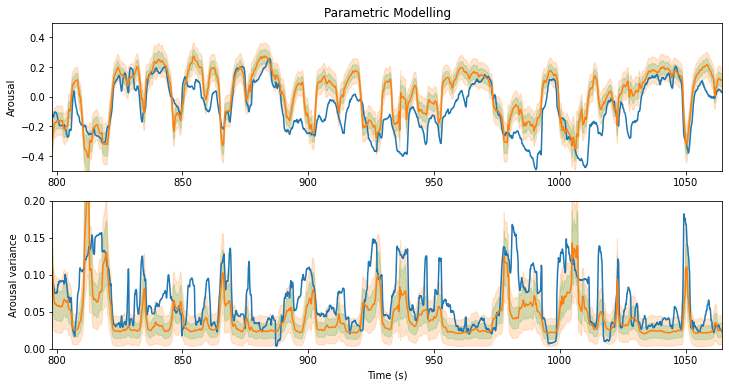

In [69]:
npresults = np.array(results_mean)
npresults_var = np.array(results_var)
time_step = 0.04*frame_step
num_steps = npresults.shape[0]
file_num = 3
time_start = file_num*time_step*num_steps/10
time_end = (file_num+1)*time_step*num_steps/10
time_stamps = np.arange(num_steps)*time_step

#test data
test = y_test[:,frame_length-1,0].flatten()
test_var = y_test_var[:,frame_length-1,0].flatten()

#model predictions
pred_mean = results_mean[:,frame_length-1,2].flatten()
pred_amb = results_var[:,frame_length-1,2].flatten()

##uncertainty
alpha = results_mean[:,frame_length-1,0].flatten()
beta = results_mean[:,frame_length-1,1].flatten()
gamma = results_mean[:,frame_length-1,2].flatten()
nu = results_mean[:,frame_length-1,3].flatten()

alpha2 = results_var[:,frame_length-1,0].flatten()
beta2 = results_var[:,frame_length-1,1].flatten()
gamma2 = results_var[:,frame_length-1,2].flatten()
nu2 = results_var[:,frame_length-1,3].flatten()

#data uncertainty
dunc_mean = beta/(alpha-1)
dunc_amb = beta2/(alpha2-1)

#model uncertainty
munc_mean = dunc_mean/nu
munc_amb = dunc_amb/nu2

#total uncertainty
tunc_mean = np.sqrt(munc_mean+dunc_mean)
tunc_amb = np.sqrt(munc_amb+dunc_amb)

fig, axs = plt.subplots(2)
fig.set_size_inches(12,6)
axs[0].set_title('Parametric Modelling')

axs[0].set_xlim([time_start,time_end])
# axs[0].set_xlim([0,66519])
axs[0].set_ylim([-0.5,0.5])
# axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Arousal')
axs[0].plot(time_stamps, test, label='Mean annotation')
axs[0].plot(time_stamps, pred_mean, label='Prediction')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
# axs[0].plot(np.sqrt(munc_mean)-1, label='predicted model uncertainty - 1')
# axs[0].plot(np.sqrt()-1, label='predicted data uncertainty - 1')
axs[0].fill_between(time_stamps, pred_mean-tunc_mean,pred_mean+tunc_mean,color='C1',alpha=0.2, label='Total uncertainty')
axs[0].fill_between(time_stamps, pred_mean-np.sqrt(munc_mean),pred_mean+np.sqrt(munc_mean),color='C2',alpha=0.2, label='Model uncertainty')
# axs[0].legend(loc='upper right')

axs[1].set_xlim([time_start,time_end])
# axs[1].set_xlim([0,66519])
axs[1].set_ylim([0,0.2])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Arousal variance')
axs[1].plot(time_stamps, test_var, label='Inter-rater variance')
axs[1].plot(time_stamps, pred_amb, label='Predicted ambiguity')
axs[1].fill_between(time_stamps, pred_amb-tunc_amb,pred_amb+tunc_amb,color='C1',alpha=0.2, label='Total uncertainty')
axs[1].fill_between(time_stamps, pred_amb-np.sqrt(munc_amb),pred_amb+np.sqrt(munc_amb),color='C2',alpha=0.2, label='Model uncertainty')
# axs[1].legend(loc='upper right')

print(my_ccc(test,pred_mean))
print(my_ccc(test_var,pred_amb))
print(my_ccc(np.sqrt(test_var),np.sqrt(pred_amb)))
print(my_nll(y_test_multi, pred_mean, np.sqrt(pred_amb+dunc_mean+munc_mean)))
print(my_nll(y_test_multi, pred_mean, np.sqrt(pred_amb+dunc_mean)))
# print(np.mean(munc[:,0,0]))
# print(np.mean(dunc[:,0,0]))
# print(np.mean(munc[:,1,1]))
# print(np.mean(dunc[:,1,1]))

In [49]:
np.sqrt(np.mean((test-pred_mean)**2))

0.13658981064777728

In [50]:
np.sqrt(np.mean((test_var-pred_amb)**2))

0.037412822344998174

In [51]:
np.sqrt(np.mean((np.sqrt(test_var)-np.sqrt(pred_amb))**2))

0.06916844183365825

In [45]:
#build NIG 4 param model
def my_NIG_loss(y_true, y_pred):
    #train the model on NLL loss, given the 6 annotations
    
    nll = 0
    
    #4 parameters of NIG prior
    alpha = y_pred[:,:,0]
    beta = y_pred[:,:,1]
    gamma = y_pred[:,:,2]
    nu = y_pred[:,:,3]
    
    omega = 2*beta*(1+nu)
    rcoeff1 = 0.0001
    
    #calculate nll loss as used in Amini et al.'s DER
    nll += (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    
    #component of nll dependent on labels:
    y = tf.math.reduce_mean(y_true,axis=2)
    nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega))
    #regulariser
    nll += rcoeff1*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))

    
    #repeat for ambiguity estimate
    alpha = y_pred[:,:,4]
    beta = y_pred[:,:,5]
    gamma = y_pred[:,:,6]
    nu = y_pred[:,:,7]
    
    omega = 2*beta*(1+nu)
    rcoeff1 = 0.0001
    
    nll += (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    y = tf.math.reduce_variance(y_true,axis=2)
    nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega))
    nll += rcoeff1*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))
    
    
    return nll
    
    
inputs = Input(shape=(frame_length,88))
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(inputs)
x = Dropout(dropout_rate)(x)
x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=dropout_rate))(x)
x = Dropout(dropout_rate)(x)
alpha = Dense(1, activation="softplus")(x)
beta = Dense(1, activation="softplus")(x)
gamma = Dense(1, activation="tanh")(x)
nu = Dense(1, activation="softplus")(x)

alpha_var = Dense(1, activation="softplus")(x)
beta_var = Dense(1, activation="softplus")(x)
gamma_var = Dense(1, activation="softplus")(x)
nu_var = Dense(1, activation="softplus")(x)
outputs = Concatenate()([alpha+1, beta, gamma, nu ,alpha_var+1, beta_var, gamma_var, nu_var]) #4 parameters of NIG distribution x2

model_NIG2 = keras.Model(inputs, outputs)
model_NIG2.summary()

#train model
optimizer = keras.optimizers.Adam(learning_rate=0.00003)
model_NIG2.compile(optimizer=optimizer, loss=my_NIG_loss)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', min_delta=0.0001, restore_best_weights=True)
model_NIG2.fit(x_train,y_train_multi, batch_size=100, epochs=100, validation_data=(x_test,y_test_multi), shuffle=True, callbacks=[early_stopping])


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10, 88)]     0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 10, 128)      78336       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 10, 128)      0           bidirectional_8[0][0]            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 10, 128)      98816       dropout_8[0][0]                  
____________________________________________________________________________________________

In [47]:
results = model_NIG2.predict(x_test)
results_mean = results[:,:,0:4]
results_var = results[:,:,4:8]

print(results_var.shape)

(33264, 10, 4)


C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/4070812564.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_mean[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/4070812564.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test[index]-pred_mean[index]))))


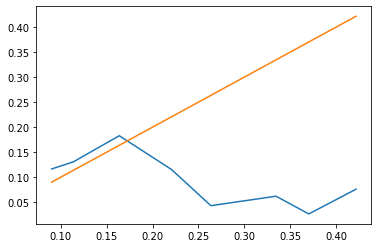

In [75]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
    index = [(tunc_mean<thresh) * (tunc_mean>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_mean[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test[index]-pred_mean[index]))))

plt.plot(conf,rmse)
plt.plot(conf,conf)

C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/628991154.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/628991154.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(pred_amb[index]-test_var[index]))))


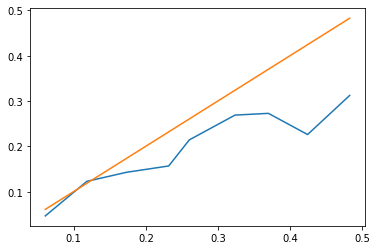

In [74]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(pred_amb[index]-test_var[index]))))

plt.plot(conf,rmse)
plt.plot(conf,conf)

C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/3885901889.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf.append(np.sqrt(np.mean(np.square(tunc_mean[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/3885901889.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rmse.append(np.sqrt(np.mean(np.square(test[index]-pred_mean[index]))))
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_11292/3885901889.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

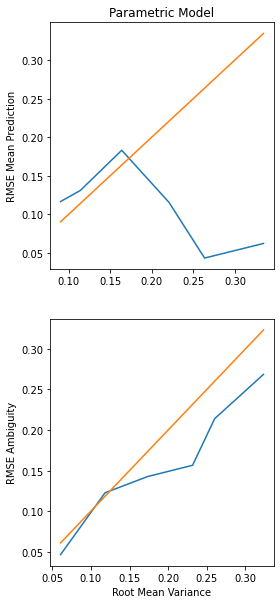

In [78]:
conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_mean<thresh) * (tunc_mean>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_mean[index]))))
    rmse.append(np.sqrt(np.mean(np.square(test[index]-pred_mean[index]))))

fig, axs = plt.subplots(2)
fig.set_size_inches(4,10)

axs[0].set_title('Parametric Model')
axs[0].set_ylabel('RMSE Mean Prediction')
axs[0].plot(conf,rmse)
axs[0].plot(conf,conf)

conf = []
rmse = []
for thresh in [0.1,0.15,0.2,0.25,0.3,0.35]:
    index = [(tunc_amb<thresh) * (tunc_amb>(thresh-0.05))]
    conf.append(np.sqrt(np.mean(np.square(tunc_amb[index]))))
    rmse.append(np.sqrt(np.mean(np.square(pred_amb[index]-test_var[index]))))

axs[1].set_xlabel('Root Mean Variance')
axs[1].set_ylabel('RMSE Ambiguity')
axs[1].plot(conf,rmse)
axs[1].plot(conf,conf)

0.31192155106561786

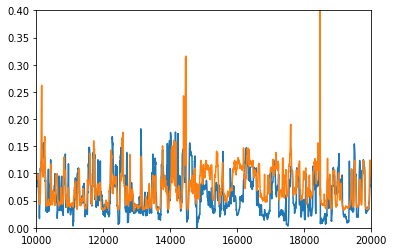

In [91]:
# plt.plot(tunc_mean)
# plt.plot(test_var)
# plt.xlim([0,5000])
# my_ccc(tunc_mean, test_var)

plt.plot(test_var)
plt.plot(np.sqrt(tunc_amb)-0.1)
plt.xlim([10000,20000])
plt.ylim([0,0.4])
my_ccc(np.sqrt(tunc_amb)-0.1, test_var)